In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as anim

# <center> Ordinary differential equations and physics Part III </center>

The method of lines provides a very quick way to convert a parabolic or hyperbolic partial differential equation into an ODE problem.

## <center> The time-dependent Schrodinger equation </center>

Consider the time-dependent Schrodinger equation, in natural units
\begin{equation}
i \partial_t \psi = \left(- \dfrac{1}{2m} \partial_x^2 + V(x,t) \right) \psi
\end{equation}
To convert this into an ODE, let us first discretize $\psi(t,x)$ in space. That is, let us define an $N$-point mesh $\{ x_i\}$ and the function evaluations,
\begin{equation}
\psi_i(t) = \psi(t,x_i)
\end{equation}
This lets us approximate the second spatial derivative around $x = x_i$ as follows,
\begin{equation}
\partial_x^2 \psi(t,x) \approx \dfrac{\psi_{i+1}(t) + \psi_{i-1}(t) - 2 \psi_i(t)}{h^2}
\end{equation}
Thus, the PDE above becomes a system of $N$ ordinary differential equations in $\psi_i(t)$.
\begin{equation}
\dfrac{d \psi_i(t)}{dt} = i \dfrac{\psi_{i+1}(t) + \psi_{i-1}(t) - 2 \psi_i(t)}{2mh^2} - i V_i(t) \psi_i(t)
\end{equation}
where
\begin{equation}
V_i(t) = V(t,x_i)
\end{equation}
That is,
\begin{equation}
\dfrac{d \vec{\psi}}{dt} = \vec{f}(t, \vec{\psi})
\end{equation}
This lets us use the machinery of Runge-Kutta integrators to integrate the time-dependent Schrodinger equation, given an initial wavefunction $\vec{\psi}(0)$.

### <center> Particle in a box </center>

Let us consider a particle in a box,
\begin{equation}
\dfrac{d \psi_i(t)}{dt} = i \dfrac{\psi_{i+1}(t) + \psi_{i-1}(t) - 2 \psi_i(t)}{2mh^2} - i V_i(t) \psi_i(t), \qquad \psi_0(t) = \psi_N(t) = 0
\end{equation}

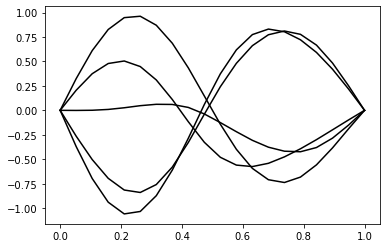

In [2]:
def rk4_int(psi, V, f, ht, hx):
    """
    Integration step according to RK4
    """
    k1 = f(psi, V, hx)
    k2 = f(psi + ht * k1/2, V, hx)
    k3 = f(psi + ht * k2/2, V, hx)
    k4 = f(psi + ht * k3, V, hx)
    
    return psi + ht * (k1 + 2 * k2 + 2 * k3 + k4) / 6

def dtpsi(psi, V, hx):
    # We must first calculate the derivative in the interior points
    imag = 1j
    
    dpsidt = imag * (psi[2:] + psi[:-2] - 2 * psi[1:-1])/(2*m*hx**2) - imag * V[1:-1]*psi[1:-1]
    
    ## Now we bring back the end points
    
    dpsidt = np.insert(dpsidt,0,0)
    dpsidt = np.append(dpsidt,0)
    
    return dpsidt

def schr_evolve(psi, V, ht, hx):
    """
    Integrates the schrodinger equation
    """
    while True:
        yield psi
        psi = rk4_int(psi, V, dtpsi, ht, hx)

m = 1
N = 20
x_mesh = np.linspace(0,1,N)
V = np.sign(x_mesh-1/2)
psi = np.sin(2*np.pi * x_mesh) * np.exp(1j * x_mesh)
psi[-1] = 0

hx = x_mesh[1]-x_mesh[0]
ht = 1E-3

evolution = schr_evolve(psi, V, ht, hx)

for k in range(1000):
    data = next(evolution)
    if k % 200 == 0:
        plt.plot(x_mesh, np.real(data), color='black')

Now we are ready to animate

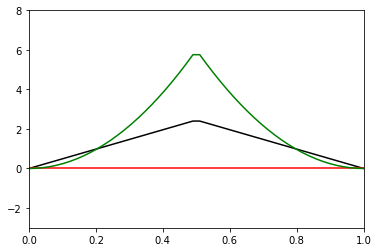

In [3]:
fig = plt.figure()
ax = plt.axes(xlim = (0,1), ylim = (-3,8))
real, = ax.plot([], [], color = 'black')
imag, = ax.plot([], [], color = 'red')
prob, = ax.plot([], [], color = 'green')

m = 1
N = 50
x_mesh = np.linspace(0,1,N)
#V = 10*(np.sign(x_mesh-1/2) + 1)
V = 50*x_mesh
psi = np.zeros(N)
k = 0
for x in x_mesh:
    if x < 0.5:
        psi[k] = 2*np.sqrt(6) * x
        #psi[k] = 0.
    else:
        psi[k] = -2*np.sqrt(6) * (x - 1) 
        #psi[k] = np.sqrt(2)
    k += 1

psi[-1] = 0

hx = x_mesh[1]-x_mesh[0]
ht = 1E-4

data = schr_evolve(psi, V, ht, hx)

def get_plot(data_gen, skip):
    def plot(n):
        psi = next(data_gen)
        real.set_data(x_mesh, np.real(psi))
        imag.set_data(x_mesh, np.imag(psi))
        prob.set_data(x_mesh, np.abs(psi)**2)
        for _ in range(skip - 1):
            psi = next(data_gen)
        return (real, imag, prob)
    return plot

plot_func = get_plot(data,20)

ani = anim.FuncAnimation(fig, plot_func, frames = 500, interval = 50, blit = True)

In [4]:
HTML(ani.to_html5_video())

## <center> Klein-Gordon equation </center>

We may apply the same idea to the free Klein-Gordon equation.
\begin{equation}
\partial^2_t \phi = \partial^2_x \phi
\end{equation}